In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from arch import arch_model
import statsmodels.api as sm
from scipy.stats import norm, t
import seaborn as sns
from arch.univariate import SkewStudent

In [3]:
# Load and prepare dataset function
def load_and_prepare_data(filename):
    data = pd.read_csv(filename, parse_dates=["Date"], index_col="Date")
    data["Return"] = 100 * (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)
    return data.dropna()

# Load datasets
ndx_data = load_and_prepare_data("^ndx_d.csv")
kospi_data = load_and_prepare_data("^kospi_d.csv")

In [ ]:
# Align datasets to start on the same date
common_start_date = max(ndx_data.index.min(), kospi_data.index.min())
ndx_data, kospi_data = ndx_data.loc[common_start_date:], kospi_data.loc[common_start_date:]

# Q1 & 2


NASDAQ-100 (^NDX)
- Observations: 9,937
- Start Date: 1985-10-02 00:00:00
- End Date: 2025-03-11 00:00:00
- Mean daily return: 0.065
- Variance: 2.675
- Standard deviation: 1.63557
- Minimum return: -15.080%
- Maximum return: 18.771%
- Median return: 0.119%
- Skewness: 0.061
- Kurtosis: 7.870


KOSPI (^KOSPI)
- Observations: 11,997
- Start Date: 1980-01-05 00:00:00
- End Date: 2025-03-12 00:00:00
- Mean daily return: 0.037
- Variance: 2.061
- Standard deviation: 1.43548
- Minimum return: -12.019%
- Maximum return: 11.946%
- Median return: 0.032%
- Skewness: -0.029
- Kurtosis: 6.116



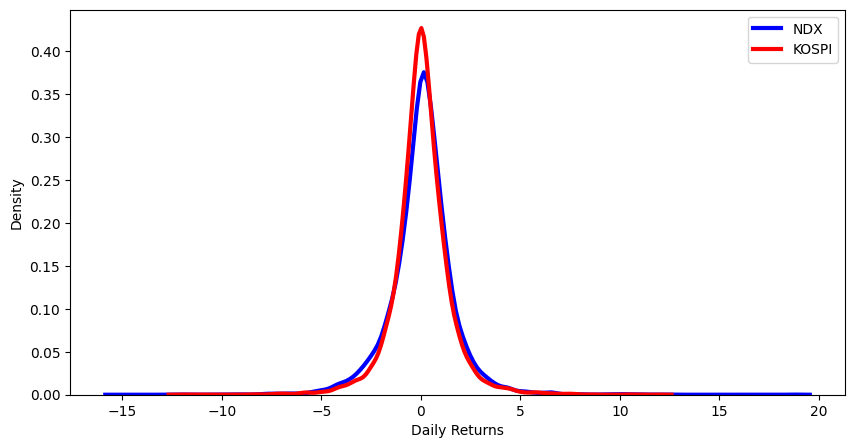

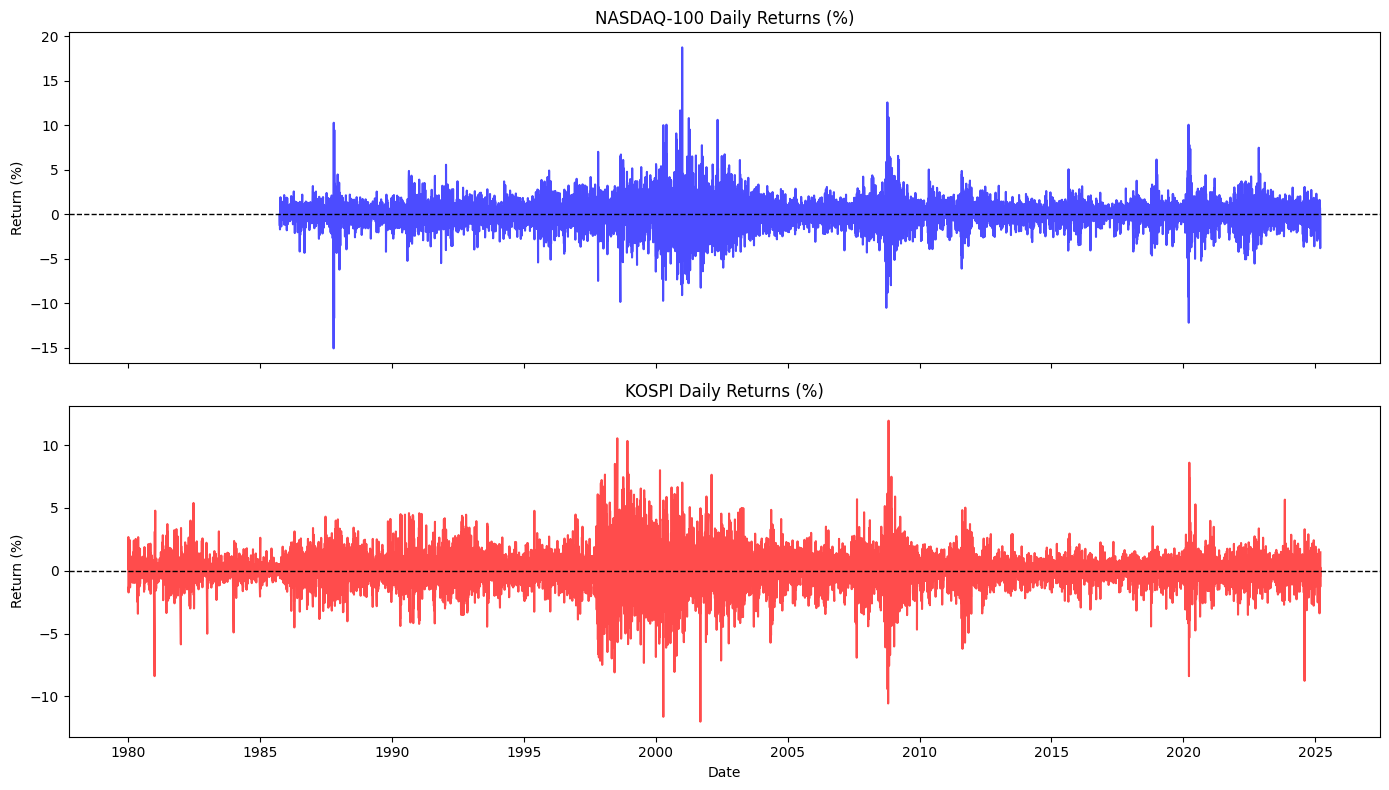

In [ ]:
# Compute statistics function
def compute_stats(data):
    returns = data["Return"]
    return {
        "Start Date": returns.index.min(),
        "End Date": returns.index.max(),
        "Observations": len(returns),
        "Mean Return": returns.mean(),
        "Variance": returns.var(),
        "Standard Deviation": returns.std(),
        "Minimum Return": returns.min(),
        "Maximum Return": returns.max(),
        "Median Return": returns.median(),
        "Skewness": stats.skew(returns),
        "Kurtosis": stats.kurtosis(returns),
    }

# Print statistics function
def print_stats(name, stats_dict):
    print(f"""
{name}
- Observations: {stats_dict["Observations"]:,}
- Start Date: {stats_dict["Start Date"]:}
- End Date: {stats_dict["End Date"]:}
- Mean daily return: {stats_dict["Mean Return"]:.3f}
- Variance: {stats_dict["Variance"]:.3f}
- Standard deviation: {stats_dict["Standard Deviation"]:.5f}
- Minimum return: {stats_dict["Minimum Return"]:.3f}%
- Maximum return: {stats_dict["Maximum Return"]:.3f}%
- Median return: {stats_dict["Median Return"]:.3f}%
- Skewness: {stats_dict["Skewness"]:.3f}
- Kurtosis: {stats_dict["Kurtosis"]:.3f}
""")

# Compute and print statistics
ndx_stats, kospi_stats = compute_stats(ndx_data), compute_stats(kospi_data)
print_stats("NASDAQ-100 (^NDX)", ndx_stats)
print_stats("KOSPI (^KOSPI)", kospi_stats)

# Create a single density plot for both indices
plt.figure(figsize=(10, 5))
sns.kdeplot(ndx_data["Return"], color="blue", label="NDX", linewidth=3)
sns.kdeplot(kospi_data["Return"], color="red", label="KOSPI", linewidth=3)
# plt.title("NDX vs KOSPI Return Density Plot")
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()


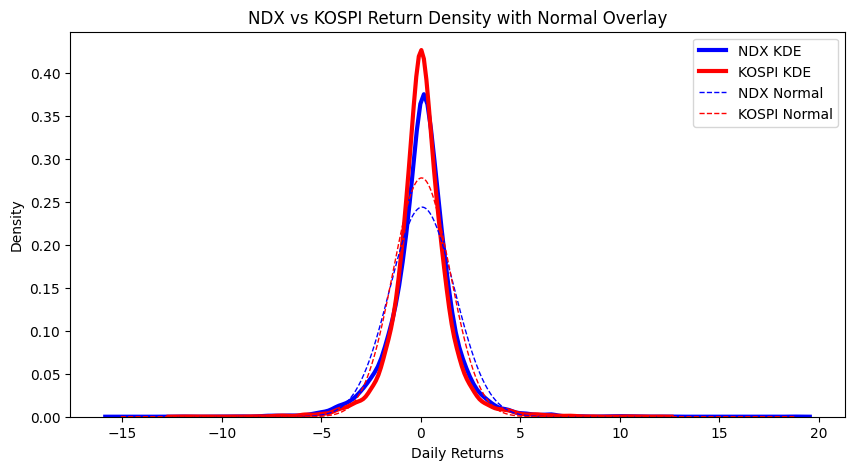

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Compute mean and standard deviation for both indices
ndx_mu, ndx_sigma = ndx_data["Return"].mean(), ndx_data["Return"].std()
kospi_mu, kospi_sigma = kospi_data["Return"].mean(), kospi_data["Return"].std()

# Generate x-values for normal distributions
x_values = np.linspace(min(ndx_data["Return"].min(), kospi_data["Return"].min()), 
                       max(ndx_data["Return"].max(), kospi_data["Return"].max()), 500)

# Compute normal density curves
ndx_norm = norm.pdf(x_values, ndx_mu, ndx_sigma)
kospi_norm = norm.pdf(x_values, kospi_mu, kospi_sigma)

# Plot KDE for NDX and KOSPI
plt.figure(figsize=(10, 5))
sns.kdeplot(ndx_data["Return"], color="blue", label="NDX KDE", linewidth=3)
sns.kdeplot(kospi_data["Return"], color="red", label="KOSPI KDE", linewidth=3)

# Plot fitted normal distributions
plt.plot(x_values, ndx_norm, color="blue", linestyle="dashed", label="NDX Normal", linewidth=1)
plt.plot(x_values, kospi_norm, color="red", linestyle="dashed", label="KOSPI Normal", linewidth=1)

# Labels and legend
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend()
plt.title("NDX vs KOSPI Return Density with Normal Overlay")

# Show plot
plt.show()

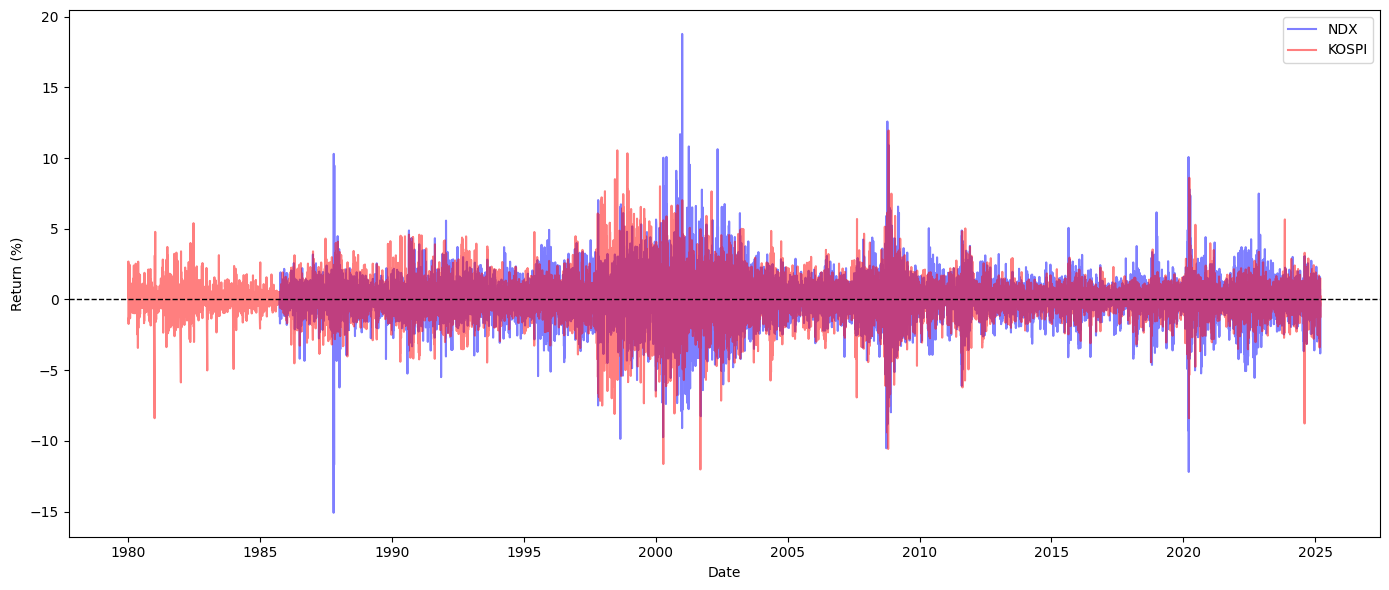

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot NASDAQ-100 returns
ax.plot(ndx_data.index, ndx_data["Return"], color="blue", alpha=0.5, label="NDX")

# Plot KOSPI returns
ax.plot(kospi_data.index, kospi_data["Return"], color="red", alpha=0.5, label="KOSPI")

# Add horizontal line at 0%
ax.axhline(0, linestyle="--", color="black", linewidth=1)

# Labels and title
# ax.set_title("NASDAQ-100 vs. KOSPI Daily Returns (%)")
ax.set_xlabel("Date")
ax.set_ylabel("Return (%)")

# Add legend
ax.legend()

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

# Q3(a)

VaR results saved to ndx_var_results.csv
VaR results saved to kospi_var_results.csv


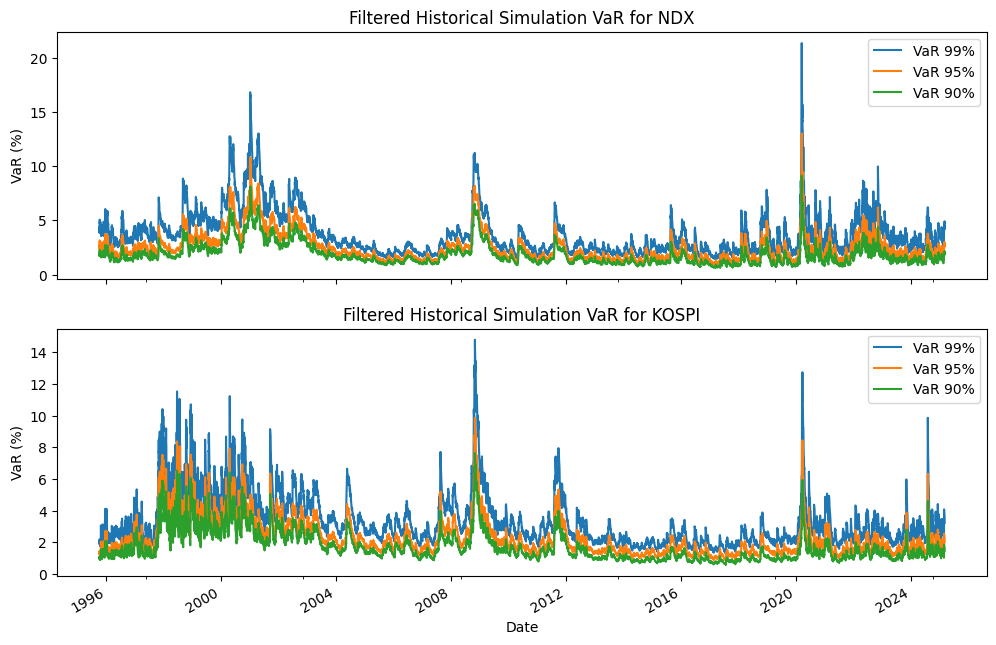

In [8]:
# Set parameters for VaR
var_levels = [0.01, 0.05, 0.10]
update_freq = 1  # Daily updates

# Function to compute FHS VaR with a rolling 10-year window
def filtered_historical_simulation(returns, update_freq, var_levels):
    start_date = returns.index.min() + pd.DateOffset(years=10)
    dates = returns.loc[start_date:].index  
    var_results = {alpha: [] for alpha in var_levels}

    for date in dates[::update_freq]:
        train_data = returns.loc[date - pd.DateOffset(years=10):date]  # 10-year rolling window

        # Fit GARCH(1,1)
        garch_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
        garch_fit = garch_model.fit(disp="off")

        # Compute standardized residuals & forecast next period's volatility
        residuals = garch_fit.std_resid
        forecast = garch_fit.forecast(horizon=1, reindex=False).variance.iloc[-1, 0]
        forecast_vol = np.sqrt(forecast)
        rolling_mean = garch_fit.params['mu']

        # Compute VaR at different levels
        for alpha in var_levels:
            var_results[alpha].append((date, -rolling_mean - forecast_vol * residuals.quantile(alpha)))

    return var_results

# Compute VaR forecasts
ndx_var = filtered_historical_simulation(ndx_data["Return"], update_freq, var_levels)
kospi_var = filtered_historical_simulation(kospi_data["Return"], update_freq, var_levels)

# Convert results to DataFrame
def var_results_to_df(var_results, var_levels):
    return pd.DataFrame({f"VaR {int((1 - alpha) * 100)}%": [v[1] for v in var_results[alpha]] for alpha in var_levels},
                        index=[v[0] for v in var_results[var_levels[0]]])

ndx_var_df = var_results_to_df(ndx_var, var_levels)
kospi_var_df = var_results_to_df(kospi_var, var_levels)

# Export results
def save_var_results(df, filename):
    filepath = filename if filename not in locals() else f"new_{filename}"
    df.to_csv(filepath, index_label="Date")
    print(f"VaR results saved to {filepath}")

save_var_results(ndx_var_df, "ndx_var_results.csv")
save_var_results(kospi_var_df, "kospi_var_results.csv")

# Plot VaR estimates
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ndx_var_df.plot(ax=axes[0], title="Filtered Historical Simulation VaR for NDX")
axes[0].set_ylabel("VaR (%)")

kospi_var_df.plot(ax=axes[1], title="Filtered Historical Simulation VaR for KOSPI")
axes[1].set_ylabel("VaR (%)")

plt.xlabel("Date")
plt.show()


# Q3(b)

In [ ]:
# Set parameters for VaR
var_levels = [0.01, 0.05, 0.10]
update_freq = 1  # Daily updates

# Function to compute FHS VaR with a rolling 10-year window
def filtered_historical_simulation(returns, update_freq, var_levels):
    start_date = returns.index.min() + pd.DateOffset(years=10)
    dates = returns.loc[start_date:].index  
    var_results = {alpha: [] for alpha in var_levels}

    for date in dates[::update_freq]:
        train_data = returns.loc[date - pd.DateOffset(years=10):date]  # 10-year rolling window

        # Fit GARCH(1,1)
        garch_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
        garch_fit = garch_model.fit(disp="off")

        # Compute standardized residuals & forecast next period's volatility
        residuals = garch_fit.std_resid
        forecast = garch_fit.forecast(horizon=1, reindex=False).variance.iloc[-1, 0]
        forecast_vol = np.sqrt(forecast)
        rolling_mean = garch_fit.params['mu']

        # Compute VaR at different levels
        for alpha in var_levels:
            var_results[alpha].append((date, -rolling_mean - forecast_vol * residuals.quantile(alpha)))

    return var_results

# Compute VaR forecasts
ndx_var = filtered_historical_simulation(ndx_data["Return"], update_freq, var_levels)
kospi_var = filtered_historical_simulation(kospi_data["Return"], update_freq, var_levels)

# Convert results to DataFrame
def var_results_to_df(var_results, var_levels):
    return pd.DataFrame({f"VaR {int((1 - alpha) * 100)}%": [v[1] for v in var_results[alpha]] for alpha in var_levels},
                        index=[v[0] for v in var_results[var_levels[0]]])

ndx_var_df = var_results_to_df(ndx_var, var_levels)
kospi_var_df = var_results_to_df(kospi_var, var_levels)

# Export results
def save_var_results(df, filename):
    filepath = filename if filename not in locals() else f"new_{filename}"
    df.to_csv(filepath, index_label="Date")
    print(f"VaR results saved to {filepath}")

save_var_results(ndx_var_df, "ndx_var_results.csv")
save_var_results(kospi_var_df, "kospi_var_results.csv")

# Plot VaR estimates
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ndx_var_df.plot(ax=axes[0], title="Filtered Historical Simulation VaR for NDX")
axes[0].set_ylabel("VaR (%)")

kospi_var_df.plot(ax=axes[1], title="Filtered Historical Simulation VaR for KOSPI")
axes[1].set_ylabel("VaR (%)")

plt.xlabel("Date")
plt.show()


# Q4

## Generalised Error

In [9]:
# Function to compute HITs (VaR violations) and export results
def compute_and_export_hits(index_name, returns, var_series_dict, output_filename):
    hit_data = {}

    # Ensure all data aligns to the same timestamps
    common_index = returns.index  # Start with the returns index
    for model_name, var_series in var_series_dict.items():
        common_index = common_index.intersection(var_series.index)  # Keep only common dates

    # Align all series to common dates
    returns = returns.loc[common_index]

    for model_name, var_series in var_series_dict.items():
        var_series = var_series.loc[common_index]  # Align VaR series
        var_actual = -var_series  # Convert to negative values for correct interpretation
        hit_series = (returns < var_actual).astype(float)  # Compute HITs

        # Store only HITs
        hit_data[f"HIT_{model_name}"] = hit_series

    # Convert to DataFrame (ONLY HIT columns)
    hit_df = pd.DataFrame(hit_data).dropna()

    # Save to CSV (ONLY HITs)
    hit_df.to_csv(output_filename, index_label="Date")

    # Print HIT rates for each model
    for model_name in var_series_dict.keys():
        print(f"{index_name} HIT rate ({model_name}): {hit_df[f'HIT_{model_name}'].mean():.4f}")

    # Compute and print correlation of HITs between models (if multiple models exist)
    if len(hit_data) > 1:
        hit_correlation = hit_df.corr()
        print(f"Correlation of HITs between models:\n{hit_correlation}")

    return hit_df

# Function to plot VaR violations (HITs)
def plot_hits(hit_dfs, title):
    plt.figure(figsize=(16, 6))

    # Fixed y-axis offsets to maintain clear visibility
    offsets = [1.0, 0.97]

    # Extract the two datasets
    (index_name_1, hit_df_1), (index_name_2, hit_df_2) = hit_dfs.items()
    
    # Get the first HIT column from each dataset
    col_1 = [c for c in hit_df_1.columns if "HIT_" in c][0]
    col_2 = [c for c in hit_df_2.columns if "HIT_" in c][0]

    # Prepare the plots with fixed offsets
    hit_plot_1 = hit_df_1[col_1].replace(0.0, np.nan).apply(lambda x: offsets[0] if x == 1 else np.nan)
    hit_plot_2 = hit_df_2[col_2].replace(0.0, np.nan).apply(lambda x: offsets[1] if x == 1 else np.nan)

    # Scatter plot with fixed markers
    plt.scatter(hit_plot_1.index, hit_plot_1, marker=".", s=15, label=f"{index_name_1} - {col_1.replace('HIT_', '')}")
    plt.scatter(hit_plot_2.index, hit_plot_2, marker=".", s=15, label=f"{index_name_2} - {col_2.replace('HIT_', '')}")

    plt.ylim(0.95, 1.02)  # Maintain spacing similar to the original
    plt.yticks([])  # Remove unnecessary y-axis ticks
    plt.ylabel("VaR Violations")
    plt.xlabel("Date")
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

NDX (FHS) HIT rate (VaR 95%): 0.0389
KOSPI (FHS) HIT rate (VaR 95%): 0.0412


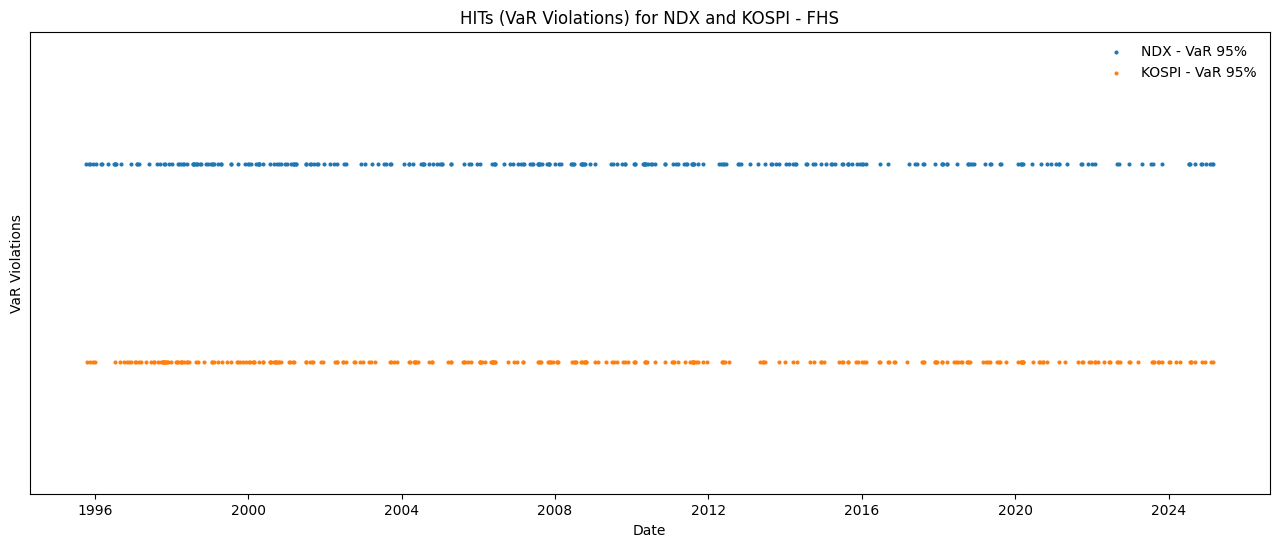

In [10]:
# Compute HITs for FHS VaR (Filtered Historical Simulation)
ndx_hits_fhs = compute_and_export_hits("NDX (FHS)", ndx_data["Return"], {"VaR 95%": ndx_var_df["VaR 95%"]}, "ndx_combined.csv")
kospi_hits_fhs = compute_and_export_hits("KOSPI (FHS)", kospi_data["Return"], {"VaR 95%": kospi_var_df["VaR 95%"]}, "kospi_combined.csv")

# Plot HITs for FHS VaR
plot_hits({"NDX": ndx_hits_fhs, "KOSPI": kospi_hits_fhs}, "HITs (VaR Violations) for NDX and KOSPI - FHS")

In [11]:
# Function to compute likelihood ratio test for each column in hits_data
def likelihood_ratio_test(index_name, hits_data, expected_rate=0.05):
    for col in hits_data:
        hit = hits_data[col]
        phat = hit.mean()  # Observed hit rate for this column
        llf = stats.bernoulli(phat).logpmf(hit).sum()  # Log-likelihood of observed rate
        llf0 = stats.bernoulli(expected_rate).logpmf(hit).sum()  # Log-likelihood under expected rate
        lr = 2 * (llf - llf0)  # Likelihood ratio test statistic
        pval = 1 - stats.chi2(1).cdf(lr)  # P-value

        print(f"{index_name} LR: {lr:.4f} P-value: {pval:.4f}")

# Apply to datasets
likelihood_ratio_test("NDX", ndx_hits_fhs)
likelihood_ratio_test("KOSPI", kospi_hits_fhs)

NDX LR: 20.8029 P-value: 0.0000
KOSPI LR: 12.7893 P-value: 0.0003


In [12]:
# Perform Christoffersen's Independence Test for both indices
def christoffersen_independence_test(index_name, hits_data):
    hits_data_new = hits_data.squeeze()
    hit_t = hits_data_new.shift(1)  # Previous day's HIT
    hit_tp1 = hits_data_new  # Current day's HIT

    # Count transitions
    n00 = ((1 - hit_t) * (1 - hit_tp1)).sum()
    n10 = (hit_t * (1 - hit_tp1)).sum()
    n01 = ((1 - hit_t) * hit_tp1).sum()
    n11 = (hit_t * hit_tp1).sum()

    # Compute transition probabilities
    p00_hat = n00 / (n00 + n01)
    p11_hat = n11 / (n11 + n10)
    p00 = p00_hat
    p11 = p11_hat
    # Compute log-likelihood for observed transition probabilities
    llf = (
        n00 * np.log(p00)
        + n10 * np.log(1 - p00)
        + n11 * np.log(p11)
        + n10 * np.log(1 - p11)
    )


    # Compute log-likelihood under independence assumption
    p11 = 0.05
    p00 = 1 - p11
    llf0 = (
        n00 * np.log(p00)
        + n10 * np.log(1 - p00)
        + n11 * np.log(p11)
        + n10 * np.log(1 - p11)
    )

    # Compute likelihood ratio test statistic
    lr = 2 * (llf - llf0)
    pval = 1 - stats.chi2(2).cdf(lr)

    print(f"Christoffersen's Test, {index_name} LR: {lr:.4f} P-value: {pval:.4f}")

# Apply Christoffersen's test to NDX and KOSPI
for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits_fhs, kospi_hits_fhs]):
    christoffersen_independence_test(index_name, hits_data)

Christoffersen's Test, NDX LR: 20.9236 P-value: 0.0000
Christoffersen's Test, KOSPI LR: 18.0357 P-value: 0.0001


In [13]:
# Function to perform OLS regression and Wald test
def ols_regression_with_wald_test(index_name, hits_data, var_df, var_col, expected_violation_rate=0.05):

    hit = hits_data - expected_violation_rate  # Adjust violations by subtracting expected rate

    # Create lagged HIT variables (5 lags)
    lags = pd.concat([hit.shift(i + 1) for i in range(5)], axis=1)

    # Select corresponding VaR column
    var = var_df[var_col]

    # Combine data for regression
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]  # Dependent variable (adjusted HIT)
    x = sm.add_constant(data.iloc[:, 1:])  # Add constant term
    x.columns = ["const", "VaR"] + [f"hit_L_{i}" for i in range(1, 6)]  # Rename columns

    # Run OLS regression
    res = sm.OLS(y, x).fit()

    # Wald test for joint significance of all coefficients (except constant)
    r = np.eye(len(x.columns))  
    joint = res.wald_test(r, scalar=True)
    
    return {
        "summary": res.summary(),
        "stat": f"Stat: {joint.statistic:.4f}, P-value: {joint.pvalue:.4f}"
    }

# Store results for FHS VaR HITs
results_fhs = {
    "NDX": ols_regression_with_wald_test("NDX", ndx_hits_fhs, ndx_var_df, "VaR 95%"),
    "KOSPI": ols_regression_with_wald_test("KOSPI", kospi_hits_fhs, kospi_var_df, "VaR 95%"),
}

# Print results for FHS
for index_name in ["NDX", "KOSPI"]:
    print(f"OLS Regression Summary for {index_name} (FHS):")
    print(results_fhs[index_name]["summary"])
    print(f"Wald Test {index_name} (FHS): {results_fhs[index_name]['stat']}\n")


OLS Regression Summary for NDX (FHS):
                            OLS Regression Results                            
Dep. Variable:            HIT_VaR 95%   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.890
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           3.83e-06
Time:                        17:32:03   Log-Likelihood:                 1677.0
No. Observations:                7402   AIC:                            -3340.
Df Residuals:                    7395   BIC:                            -3292.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

In [14]:
# Function to perform Logit and Probit regression
def logit_probit_regression(index_name, hits_data, var_df, var_col):

    hit = hits_data  # HIT variable (already 0 or 1)

    # Create lagged HIT variables (5 lags)
    lags = pd.concat([hit.shift(i + 1) for i in range(5)], axis=1)

    # Select corresponding VaR column
    var = var_df[var_col]

    # Combine data for regression
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]  # Binary target variable (HIT)
    x = sm.add_constant(data.iloc[:, 1:])  # Add intercept
    x.columns = ["const", "VaR"] + [f"hit_L_{i}" for i in range(1, 6)]  # Rename columns

    # Run Logit and Probit models
    logit_model = sm.Logit(y, x).fit(disp=0)
    probit_model = sm.Probit(y, x).fit(disp=0)

    return {
        "logit_summary": logit_model.summary(),
        "probit_summary": probit_model.summary()
    }

# Store results for FHS VaR HITs
results_fhs_logit_probit = {
    "NDX": logit_probit_regression("NDX", ndx_hits_fhs, ndx_var_df, "VaR 95%"),
    "KOSPI": logit_probit_regression("KOSPI", kospi_hits_fhs, kospi_var_df, "VaR 95%"),
}

# Print results for FHS
for index_name in ["NDX", "KOSPI"]:
    print(f"Logit Regression Summary for {index_name} (FHS):")
    print(results_fhs_logit_probit[index_name]["logit_summary"])
    print(f"\nProbit Regression Summary for {index_name} (FHS):")
    print(results_fhs_logit_probit[index_name]["probit_summary"])


Logit Regression Summary for NDX (FHS):
                           Logit Regression Results                           
Dep. Variable:            HIT_VaR 95%   No. Observations:                 7402
Model:                          Logit   Df Residuals:                     7395
Method:                           MLE   Df Model:                            6
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                 0.01206
Time:                        17:32:03   Log-Likelihood:                -1202.6
converged:                       True   LL-Null:                       -1217.3
Covariance Type:            nonrobust   LLR p-value:                 5.178e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6863      0.120    -30.739      0.000      -3.921      -3.451
VaR            0.1591      0.037      4.315      0.000       0.087       0.231
hit_L_1     

# Q5

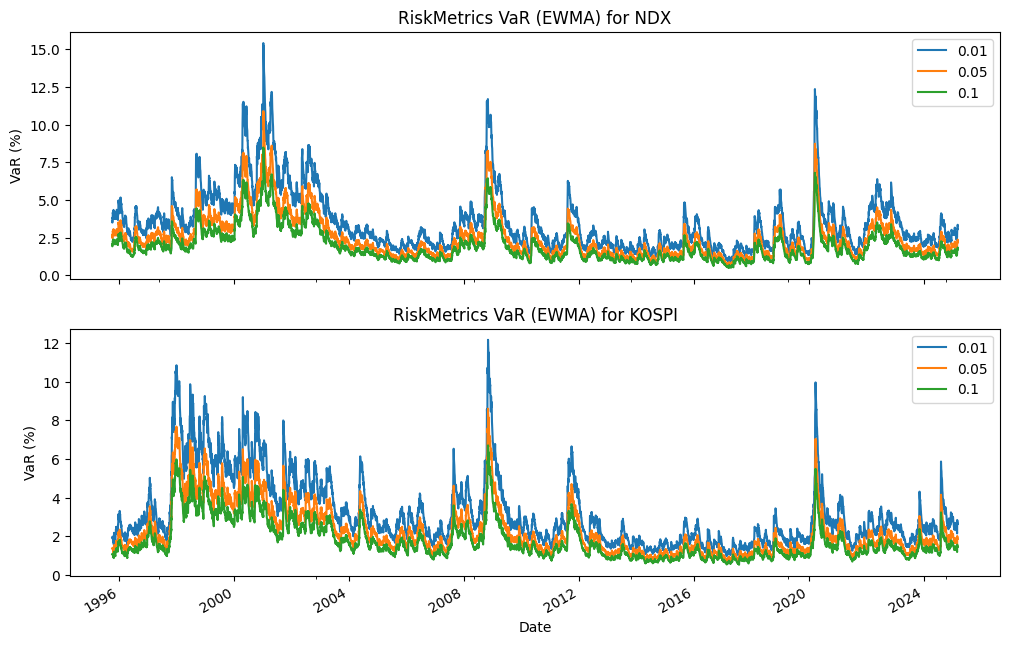

In [15]:
# Set decay factor for EWMA (RiskMetrics)
lambda_ewma = 0.94  # Daily data

# Function to compute RiskMetrics VaR using explicit summation
def riskmetrics_var_explicit(data, lambda_ewma, var_levels):
    ewma_var = np.zeros(len(data))  # Store variance estimates
    
    # Compute EWMA variance using explicit summation
    for t in range(len(data)):
        past_returns = data.iloc[:t+1]  # Take all past data up to time t
        weights = (1 - lambda_ewma) * lambda_ewma ** np.arange(len(past_returns))[::-1]  # Compute correct decay weights
        ewma_var[t] = np.sum(weights * past_returns**2)  # Apply formula

    ewma_vol = np.sqrt(ewma_var)  # Convert variance to standard deviation

    # Compute VaR for different confidence levels using normal quantiles
    var_results = {alpha: -ewma_vol * stats.norm.ppf(alpha) for alpha in var_levels}  # % VaR

    return pd.DataFrame(var_results, index=data.index)

# Compute RiskMetrics VaR for NDX and KOSPI using explicit summation
ndx_var_riskmetrics_explicit = riskmetrics_var_explicit(ndx_data["Return"].dropna(), lambda_ewma, [0.01, 0.05, 0.10])
kospi_var_riskmetrics_explicit = riskmetrics_var_explicit(kospi_data["Return"].dropna(), lambda_ewma, [0.01, 0.05, 0.10])

# Find the first date where FHS VaR is available
first_ndx_var_date = ndx_var_df.index.min()
first_kospi_var_date = kospi_var_df.index.min()

# Trim RiskMetrics VaR data to start from the same date as FHS VaR
ndx_var_riskmetrics_explicit = ndx_var_riskmetrics_explicit.loc[first_ndx_var_date:]
kospi_var_riskmetrics_explicit = kospi_var_riskmetrics_explicit.loc[first_kospi_var_date:]

# Plot RiskMetrics VaR
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# NDX VaR
ndx_var_riskmetrics_explicit.plot(ax=axes[0], title="RiskMetrics VaR (EWMA) for NDX")
axes[0].set_ylabel("VaR (%)")

# KOSPI VaR
kospi_var_riskmetrics_explicit.plot(ax=axes[1], title="RiskMetrics VaR (EWMA) for KOSPI")
axes[1].set_ylabel("VaR (%)")

plt.xlabel("Date")
plt.show()


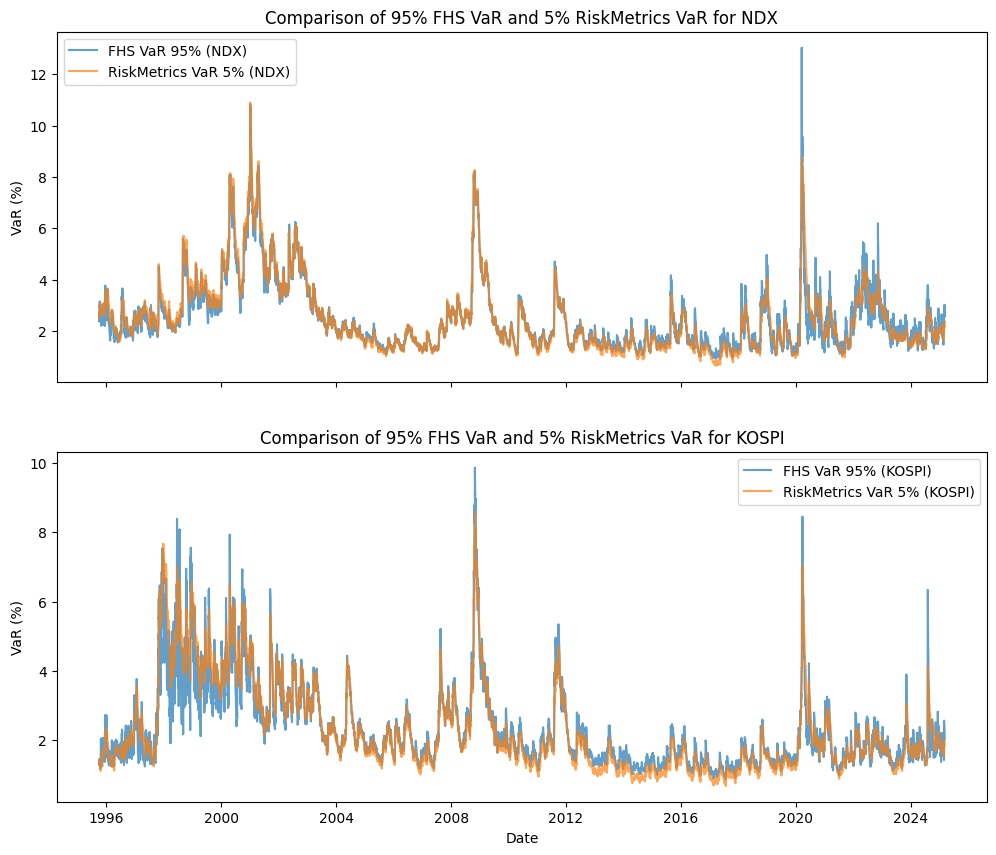

In [16]:
# Compare 5% alpha results of FHS VaR and RiskMetrics VaR
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 95% VaR for NDX
axes[0].plot(ndx_var_df.index, ndx_var_df["VaR 95%"], label="FHS VaR 95% (NDX)", linestyle="-", alpha=0.7)
axes[0].plot(ndx_var_riskmetrics_explicit.index, ndx_var_riskmetrics_explicit[0.05], label="RiskMetrics VaR 5% (NDX)", linestyle="-", alpha=0.7)
axes[0].set_title("Comparison of 95% FHS VaR and 5% RiskMetrics VaR for NDX")
axes[0].set_ylabel("VaR (%)")
axes[0].legend()

# Plot 95% VaR for KOSPI
axes[1].plot(kospi_var_df.index, kospi_var_df["VaR 95%"], label="FHS VaR 95% (KOSPI)", linestyle="-", alpha=0.7)
axes[1].plot(kospi_var_riskmetrics_explicit.index, kospi_var_riskmetrics_explicit[0.05], label="RiskMetrics VaR 5% (KOSPI)", linestyle="-", alpha=0.7)
axes[1].set_title("Comparison of 95% FHS VaR and 5% RiskMetrics VaR for KOSPI")
axes[1].set_ylabel("VaR (%)")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.show()


NDX (RiskMetrics) HIT rate (VaR 95%): 0.0468
KOSPI (RiskMetrics) HIT rate (VaR 95%): 0.0531


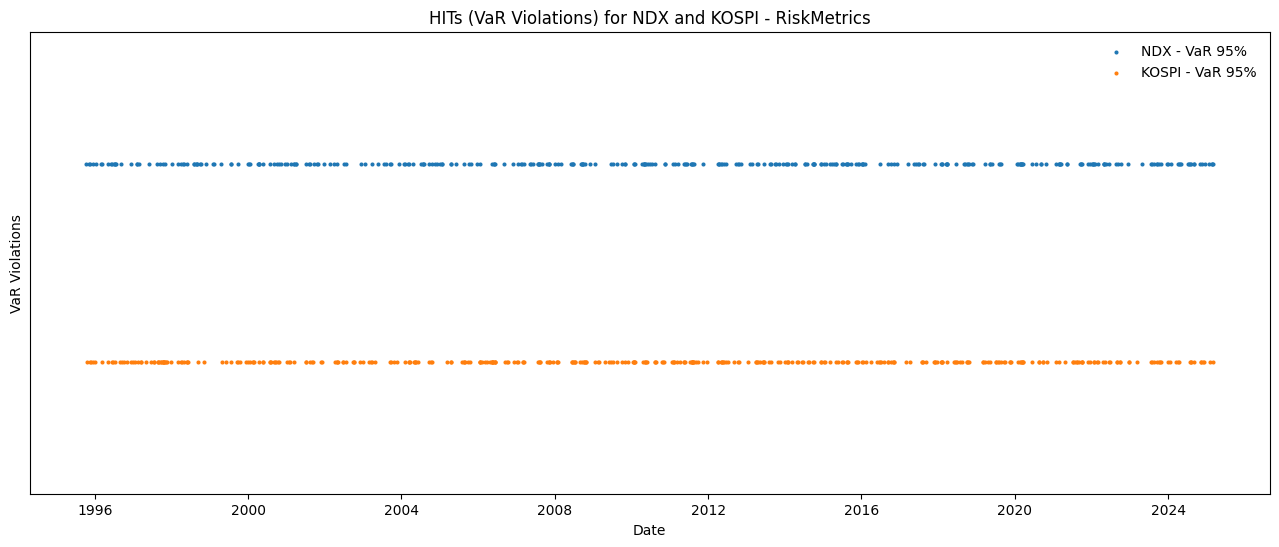

In [17]:
# Compute HITs for RiskMetrics VaR (EWMA model)
ndx_hits_riskmetrics = compute_and_export_hits("NDX (RiskMetrics)", ndx_data["Return"], {"VaR 95%": ndx_var_riskmetrics_explicit[0.05]}, "ndx_combined2.csv")
kospi_hits_riskmetrics = compute_and_export_hits("KOSPI (RiskMetrics)", kospi_data["Return"], {"VaR 95%": kospi_var_riskmetrics_explicit[0.05]}, "kospi_combined2.csv")

# Plot HITs for RiskMetrics VaR
plot_hits({"NDX": ndx_hits_riskmetrics, "KOSPI": kospi_hits_riskmetrics}, "HITs (VaR Violations) for NDX and KOSPI - RiskMetrics")

In [18]:
# Apply likelihood ratio test for RiskMetrics VaR HITs
for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits_riskmetrics, kospi_hits_riskmetrics]):
    likelihood_ratio_test(index_name, hits_data)

NDX LR: 1.5815 P-value: 0.2085
KOSPI LR: 1.4802 P-value: 0.2237


In [19]:
# Apply Christoffersen's Independence Test for RiskMetrics VaR HITs
for index_name, hits_data in zip(["NDX", "KOSPI"], [ndx_hits_riskmetrics, kospi_hits_riskmetrics]):
    christoffersen_independence_test(index_name, hits_data)

Christoffersen's Test, NDX LR: 1.9357 P-value: 0.3799
Christoffersen's Test, KOSPI LR: 8.3508 P-value: 0.0154


In [20]:
# Store results for RiskMetrics VaR HITs
results_riskmetrics = {
    "NDX": ols_regression_with_wald_test("NDX", ndx_hits_riskmetrics, ndx_var_riskmetrics_explicit, var_col=0.05),
    "KOSPI": ols_regression_with_wald_test("KOSPI", kospi_hits_riskmetrics, kospi_var_riskmetrics_explicit, var_col=0.05),
}

# Print results for RiskMetrics
for index_name in ["NDX", "KOSPI"]:
    print(f"OLS Regression Summary for {index_name} (RiskMetrics):")
    print(results_riskmetrics[index_name]["summary"])
    print(f"Wald Test {index_name} (RiskMetrics): {results_riskmetrics[index_name]['stat']}\n")


OLS Regression Summary for NDX (RiskMetrics):
                            OLS Regression Results                            
Dep. Variable:            HIT_VaR 95%   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.683
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           9.19e-05
Time:                        17:32:08   Log-Likelihood:                 1014.5
No. Observations:                7402   AIC:                            -2015.
Df Residuals:                    7395   BIC:                            -1967.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

In [21]:
# Store results for RiskMetrics VaR HITs
results_riskmetrics_logit_probit = {
    "NDX": logit_probit_regression("NDX", ndx_hits_riskmetrics, ndx_var_riskmetrics_explicit, var_col=0.05),
    "KOSPI": logit_probit_regression("KOSPI", kospi_hits_riskmetrics, kospi_var_riskmetrics_explicit, var_col=0.05),
}

# Print results for RiskMetrics
for index_name in ["NDX", "KOSPI"]:
    print(f"Logit Regression Summary for {index_name} (RiskMetrics):")
    print(results_riskmetrics_logit_probit[index_name]["logit_summary"])
    print(f"\nProbit Regression Summary for {index_name} (RiskMetrics):")
    print(results_riskmetrics_logit_probit[index_name]["probit_summary"])

Logit Regression Summary for NDX (RiskMetrics):
                           Logit Regression Results                           
Dep. Variable:            HIT_VaR 95%   No. Observations:                 7402
Model:                          Logit   Df Residuals:                     7395
Method:                           MLE   Df Model:                            6
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                0.008237
Time:                        17:32:08   Log-Likelihood:                -1389.1
converged:                       True   LL-Null:                       -1400.6
Covariance Type:            nonrobust   LLR p-value:                 0.0007723
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1728      0.113    -28.001      0.000      -3.395      -2.951
VaR            0.0260      0.038      0.690      0.490      -0.048       0.100
hit_

In [113]:
def tick_loss(returns, var_estimates, alpha=0.05):
    indicator = (returns < var_estimates).astype(int)  # Corrected logic
    return alpha * (returns - var_estimates) * (1 - indicator) + (1 - alpha) * (var_estimates - returns) * indicator

def diebold_mariano_test(index_name, returns, var_model_1, var_model_2, alpha=0.05):
    """ Diebold-Mariano test using OLS with HAC standard errors """

    # Convert VaRs to negative values (since VaR represents expected losses)
    var_model_1_actual = -var_model_1
    var_model_2_actual = -var_model_2

    # Compute tick losses
    loss_model_1 = tick_loss(returns, var_model_1_actual, alpha)
    loss_model_2 = tick_loss(returns, var_model_2_actual, alpha)

    # Compute loss differential
    d_t = loss_model_1 - loss_model_2
    d_t = d_t.dropna()

    # Define OLS regression model (d_t ~ constant)
    X = np.ones_like(d_t)  # Constant term for regression
    ols_model = sm.OLS(d_t, X).fit(cov_type="HAC", cov_kwds={"maxlags": int(1.2 * len(d_t) ** (1 / 3)), "use_correction": False})  # HAC standard errors

    # Extract key statistics
    dm_stat = ols_model.params.iloc[0] / ols_model.bse.iloc[0]
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))  # Two-tailed p-value

    print(f"DM Statistics for {index_name}: {dm_stat}, P-value: {p_value}")

In [114]:
# Align daily returns with VaR data
ndx_returns = ndx_data["Return"].loc[ndx_var_riskmetrics_explicit.index]
kospi_returns = kospi_data["Return"].loc[kospi_var_riskmetrics_explicit.index]

# Align FHS VaR with RiskMetrics VaR for comparison
ndx_var_fhs_series = ndx_var_df["VaR 95%"].loc[ndx_var_riskmetrics_explicit.index]
kospi_var_fhs_series = kospi_var_df["VaR 95%"].loc[kospi_var_riskmetrics_explicit.index]

# Run Diebold-Mariano Test for NDX and KOSPI
diebold_mariano_test("NDX", ndx_returns, ndx_var_fhs_series, ndx_var_riskmetrics_explicit[0.05])
diebold_mariano_test("KOSPI", kospi_returns, kospi_var_fhs_series, kospi_var_riskmetrics_explicit[0.05])

DM Statistics for NDX: -5.977633299521206, P-value: 2.264026521814344e-09
DM Statistics for KOSPI: -8.91895561175912, P-value: 0.0


# Q6

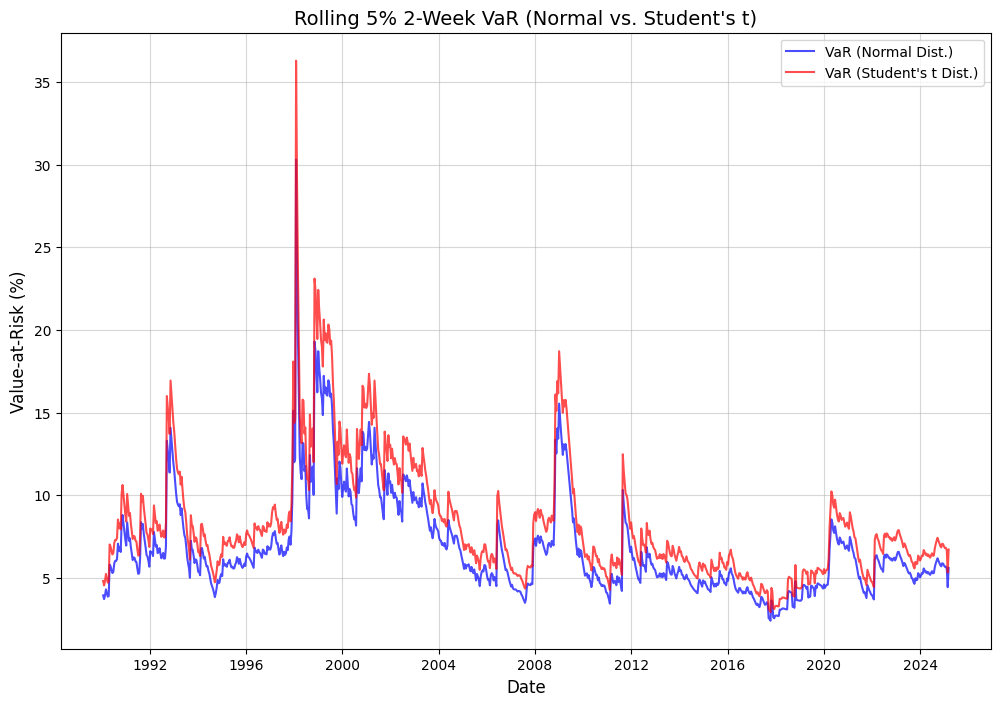

In [110]:
# Load and preprocess KOSPI data
kospi = pd.read_csv("^kospi_d.csv", parse_dates=["Date"], index_col="Date")
kospi = kospi.sort_index()

# Resample to get Thursday closing prices (biweekly non-overlapping returns)
thursday_prices = kospi.resample("W-THU").last()
non_overlapping_thursdays = thursday_prices.iloc[::2]

# Compute non-overlapping returns
returns = (non_overlapping_thursdays["Close"] - non_overlapping_thursdays["Close"].shift(1)) / non_overlapping_thursdays["Close"].shift(1) * 100
returns = returns.dropna()

# Define initial 10-year rolling window
start_date = returns.index.min()
end_date = start_date + pd.DateOffset(years=10)
first_10_years_returns = returns.loc[start_date:end_date]

# Fit initial GARCH(1,1) model with a constant mean
garch_model = arch_model(first_10_years_returns, vol="Garch", p=1, q=1, mean="Constant")
garch_fit = garch_model.fit(disp="off")

# Forecast volatility for the next 2-week period
forecast = garch_fit.forecast(horizon=1)
volatility_forecast = np.sqrt(forecast.variance.iloc[-1].mean())

# Estimated mean return
estimated_mean = garch_fit.params["mu"]

# Compute 5% VaR assuming normal distribution
z_score = norm.ppf(0.05)
VaR_5_percent_norm = -estimated_mean - z_score * volatility_forecast

# Compute 5% VaR assuming Student's t-distribution
params = t.fit(first_10_years_returns)
degrees_of_freedom = params[0]
t_quantile = t.ppf(0.05, df=degrees_of_freedom)
VaR_5_percent_t = -estimated_mean - t_quantile * volatility_forecast

# Rolling window size
window_size = len(first_10_years_returns)

# Initialize lists to store VaR values
var_5_percent_norm_list, var_5_percent_t_list = [], []

# Rolling window estimation
for i in range(len(returns) - window_size):
    rolling_sample = returns.iloc[i : i + window_size]

    # Fit GARCH(1,1) model
    garch_model = arch_model(rolling_sample, vol="Garch", p=1, q=1, mean="Constant")
    garch_fit = garch_model.fit(disp="off")

    # Forecast volatility
    forecast = garch_fit.forecast(horizon=1)
    volatility_forecast = np.sqrt(forecast.variance.iloc[-1].mean())

    # Estimated mean return
    estimated_mean = garch_fit.params["mu"]

    # Compute VaR for both distributions
    VaR_5_p_norm = -estimated_mean - z_score * volatility_forecast
    VaR_5_p_t = -estimated_mean - t_quantile * volatility_forecast

    var_5_percent_norm_list.append(VaR_5_p_norm)
    var_5_percent_t_list.append(VaR_5_p_t)

# Convert the VaR lists to Series with timestamps
var_norm_series = pd.Series(var_5_percent_norm_list, index=returns.index[window_size:])
var_t_series = pd.Series(var_5_percent_t_list, index=returns.index[window_size:])

# Plot the two VaR series
plt.figure(figsize=(12, 8))
plt.plot(var_norm_series, label="VaR (Normal Dist.)", linestyle="-", color="blue", alpha=0.7)
plt.plot(var_t_series, label="VaR (Student's t Dist.)", linestyle="-", color="red", alpha=0.7)

# Add titles and labels
plt.title("Rolling 5% 2-Week VaR (Normal vs. Student's t)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value-at-Risk (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="-", alpha=0.5)

# Show the plot
plt.show()


In [115]:
# Ensure all datasets have matching timestamps
returns = returns.loc[var_norm_series.index]  # Align returns with the VaR series
var_t_series = var_t_series.loc[var_norm_series.index]

# Run Diebold-Mariano test for Normal VaR vs. t-distributed VaR
diebold_mariano_test("KOSPI", returns, var_t_series, var_norm_series, alpha=0.05)

DM Statistics for KOSPI: 1.8201512331728853, P-value: 0.0687359772833731


# Q7 (a)

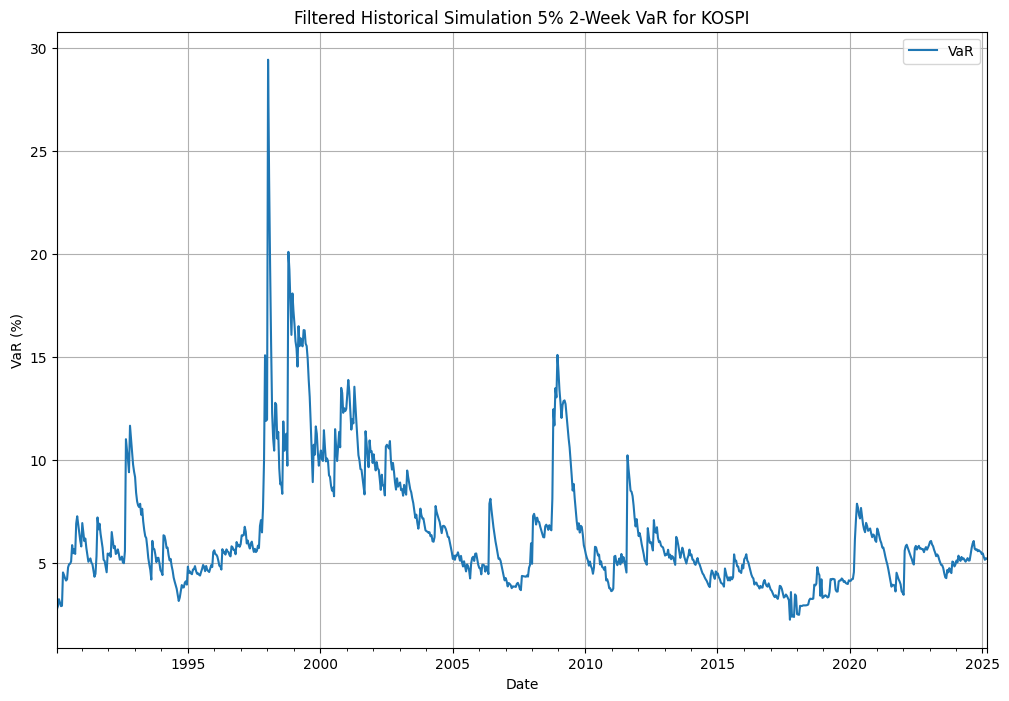

In [112]:
# Load dataset and preprocess biweekly returns
kospi_data_new = pd.read_csv("^kospi_d.csv", parse_dates=["Date"], index_col="Date").sort_index()

# Resample to get Thursday closing prices (biweekly)
thursday_prices = kospi_data_new.resample("W-THU").last()
biweekly_prices = thursday_prices.iloc[::2]

# Compute biweekly returns and scale by 100
biweekly_returns = (biweekly_prices["Close"] - biweekly_prices["Close"].shift(1)) / biweekly_prices["Close"].shift(1) * 100
biweekly_returns = biweekly_returns.dropna()  # Remove NaNs from the first row

# Compute FHS VaR for 5% level using biweekly returns
kospi_var_fhs_biweekly = filtered_historical_simulation(biweekly_returns, update_freq=1, var_levels=[0.05])


# Convert dictionary to DataFrame
kospi_var_fhs_biweekly_df = pd.DataFrame(kospi_var_fhs_biweekly[0.05], columns=["Date", "VaR"]).set_index("Date")

# Plot the FHS VaR estimates
plt.figure(figsize=(12, 8))
kospi_var_fhs_biweekly_df["VaR"].plot(title="Filtered Historical Simulation 5% 2-Week VaR for KOSPI", legend=True)
plt.ylabel("VaR (%)")
plt.xlabel("Date")
plt.grid()
plt.show()

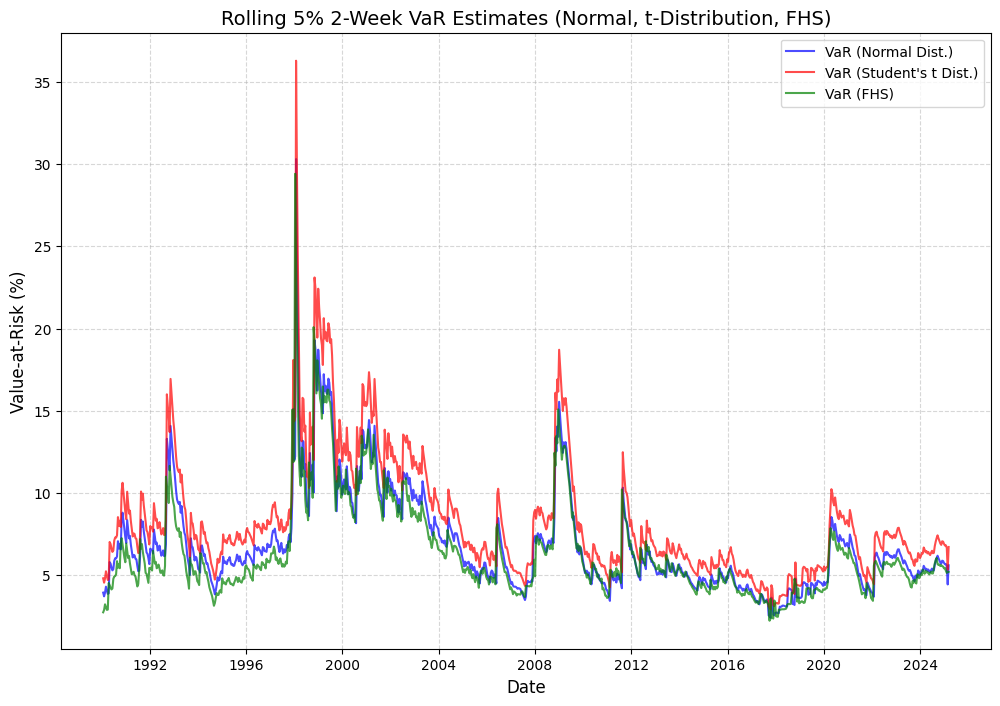

In [117]:
# Ensure all series have the same date index range
vaR_combined = pd.concat([var_norm_series, var_t_series, kospi_var_fhs_biweekly_df["VaR"]], axis=1)
vaR_combined.columns = ["VaR (Normal Dist.)", "VaR (Student's t Dist.)", "VaR (FHS)"]
vaR_combined.dropna(inplace=True)  # Ensure aligned series

# Plot the three VaR estimates
plt.figure(figsize=(12, 8))
plt.plot(vaR_combined.index, vaR_combined["VaR (Normal Dist.)"], label="VaR (Normal Dist.)", linestyle="-", color="blue", alpha=0.7)
plt.plot(vaR_combined.index, vaR_combined["VaR (Student's t Dist.)"], label="VaR (Student's t Dist.)", linestyle="-", color="red", alpha=0.7)
plt.plot(vaR_combined.index, vaR_combined["VaR (FHS)"], label="VaR (FHS)", linestyle="-", color="green", alpha=0.7)

# Formatting
plt.title("Rolling 5% 2-Week VaR Estimates (Normal, t-Distribution, FHS)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value-at-Risk (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()


In [116]:
# Align returns with VaR data
returns = biweekly_returns.loc[var_norm_series.index]  
var_fhs_series = kospi_var_fhs_biweekly_df["VaR"].loc[var_norm_series.index]  # Use correct FHS VaR

# Run the Diebold-Mariano test
diebold_mariano_test("KOSPI (Biweekly)", returns, var_fhs_series, var_norm_series, alpha=0.05)


DM Statistics for KOSPI (Biweekly): -5.780761988354861, P-value: 7.4363035729163585e-09


KOSPI (Biweekly) HIT rate (VaR_Normal): 0.0578
KOSPI (Biweekly) HIT rate (VaR_FHS): 0.0480


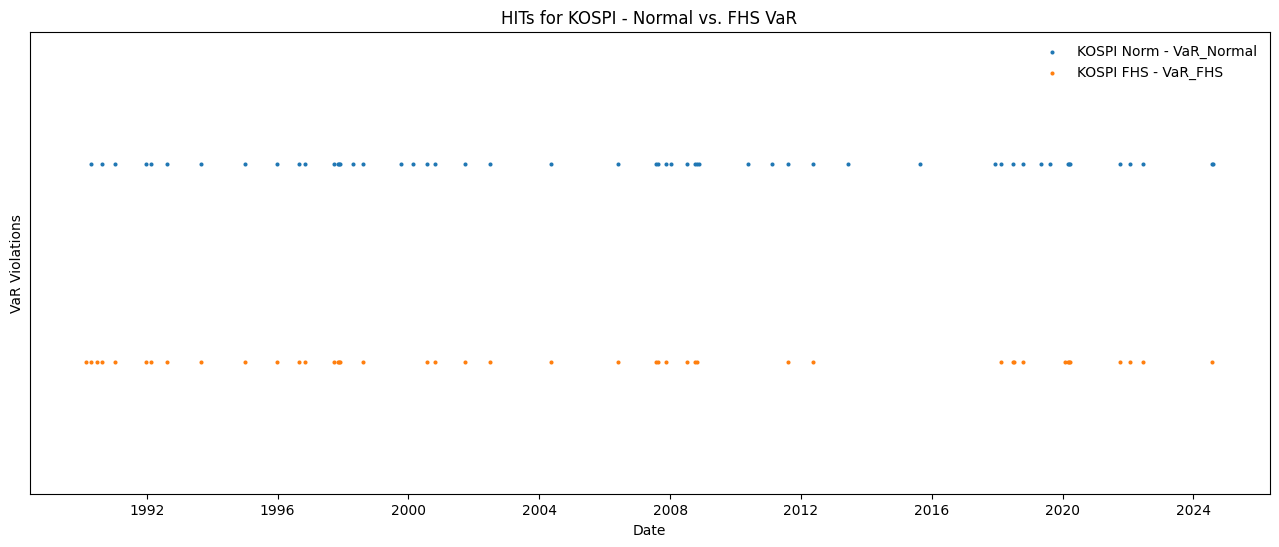

In [ ]:
# Ensure datasets have matching timestamps
returns = biweekly_returns.loc[var_norm_series.index]
var_fhs_series = kospi_var_fhs_biweekly_df["VaR"].loc[var_norm_series.index]

# Compute HITs for KOSPI
kospi_hits_norm_df = compute_and_export_hits("KOSPI (Biweekly)", returns, {"VaR_Normal": var_norm_series}, "kospi_hits_norm.csv")
kospi_hits_fhs_df = compute_and_export_hits("KOSPI (Biweekly)", returns, {"VaR_FHS": var_fhs_series}, "kospi_hits_fhs.csv")

# Plot HITs
plot_hits({"KOSPI Norm": kospi_hits_norm_df, "KOSPI FHS": kospi_hits_fhs_df}, "HITs for KOSPI - Normal vs. FHS VaR")

# Q7 (b)

In [118]:
print("fuck")

fuck
